In [2]:
from models import Discriminator, UNet, Generator
from datasets import ImageDataset,tophat
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch
import torchvision
from skimage import io, morphology
import matplotlib.pyplot as plt
import numpy as np
from models import UNet,Generator
from PIL import Image,ImageOps
from tqdm import tqdm
import random
import cv2
from utils import fusion_predict, make_mask, merge_ckpts, denorm, clear_mask
from pathlib import Path
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 多角度融合

20140101_00037465_35


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2c5029d390>,
 <matplotlib.image.AxesImage at 0x7f2c50202b90>)

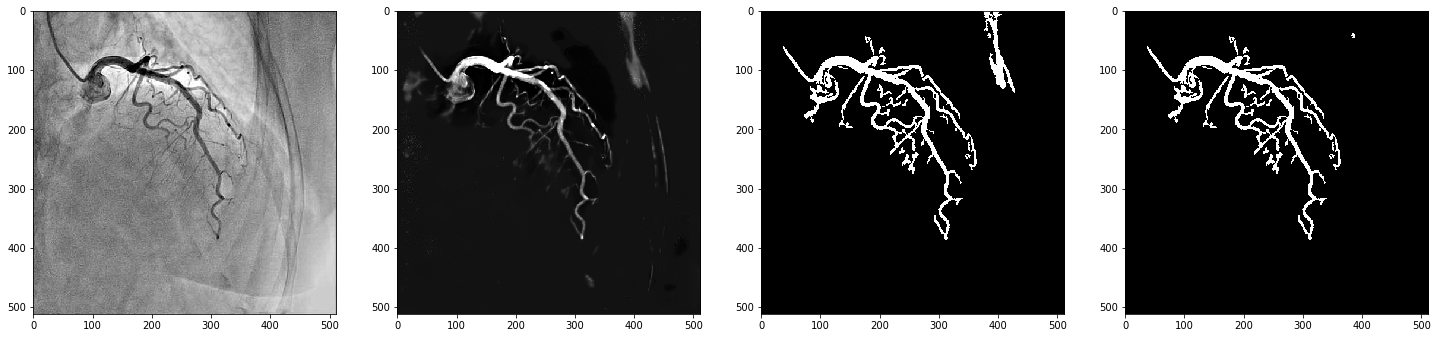

In [78]:
sz = 512
tfmc1 = T.Compose([
    T.Resize(sz),
#     T.Lambda(lambda img: tophat(img,50)),
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

tfmc2 = T.Compose([
    T.Resize(sz),
    T.Lambda(lambda img: tophat(img,50)),
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

ds1 = ImageDataset('datasets/cycledsa_v46/', size=sz, unaligned=False, mode='test', transform=tfmc1)
ds2 = ImageDataset('datasets/cycledsa_v46/', size=sz, unaligned=False, mode='test', transform=tfmc2)

netG_B2A = UNet(1, 1, 32, bilinear=True)
netG_B2A = torch.nn.DataParallel(netG_B2A)
ckpts = [
#        'mlruns/4/1b739448a0194e1e92f159d4bbc5e965/039.ckpt', # v46
#        'mlruns/4/1b739448a0194e1e92f159d4bbc5e965/035.ckpt', # v46-tophat
#        'mlruns/4/d8ec4f94fb6c41898ccf20162c5a0ba3/059.ckpt', # v46-ep60
#         'mlruns/4/ebb5a026a1264aa0a6b207adab540040/last.ckpt', # lr1e5
#             'mlruns/4/62e89ceac46145978a06cfd7ad765bfd/last.ckpt', # fulltophat
        'mlruns/4/da9110cc64c24cb08fc23984966bc62a/last.ckpt', # rot
]


idx = 59
# 缺 28 57 68 815 817 113 85
# 差2 29 
# 34 813 43 101可以作为tophat融合的样本
# 病变 805 903 951 102
# 45 126去噪样本 735
x1 = ds1[idx]['B']
x2 = ds2[idx]['B']
fname = ds1.files_B[idx]
fname = Path(fname).name.split('.')[0]
print(fname)

B1,out1 = fusion_predict(netG_B2A, ckpts, x1, multiangle=False, denoise=3, size=sz, cutoff=0.5, pad=0)
B2,out2 = fusion_predict(netG_B2A, ckpts, x2, multiangle=False, denoise=3, size=sz, cutoff=0.5, pad=0)
mask1 = make_mask(out1,remove_size=0, local_kernel=25, hole_max_size=50)
mask2 = make_mask(out2,remove_size=0, local_kernel=25, hole_max_size=50)

out_merge = Image.fromarray(np.expand_dims(np.max(np.concatenate((np.array(out1),np.array(out2)),axis=2),axis=2),2).repeat(3,2))

mask_merge = make_mask(out_merge,remove_size=2000, local_kernel=21, hole_max_size=50)
out_merge = T.functional.adjust_gamma(out_merge,2)





mask_cld = clear_mask(mask_merge)

plt.figure(figsize=(25,25))
plt.subplot(141),plt.imshow(B2)
plt.subplot(142),plt.imshow(out_merge)
plt.subplot(143),plt.imshow(mask_merge,cmap='gray')
plt.subplot(144),plt.imshow(mask_cld,cmap='gray')
    

# plt.subplot(144),plt.imshow(skel1)

# plt.show()

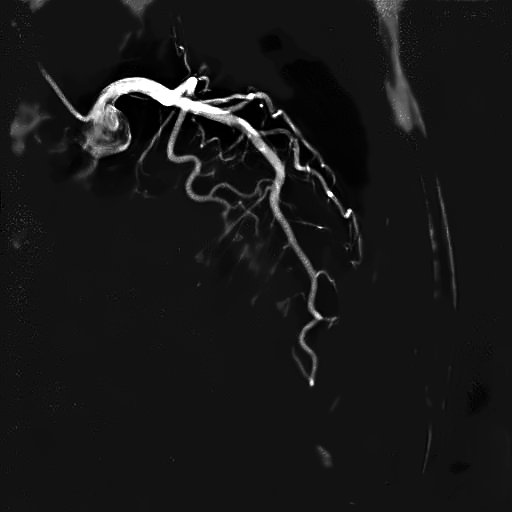

In [79]:
out_merge

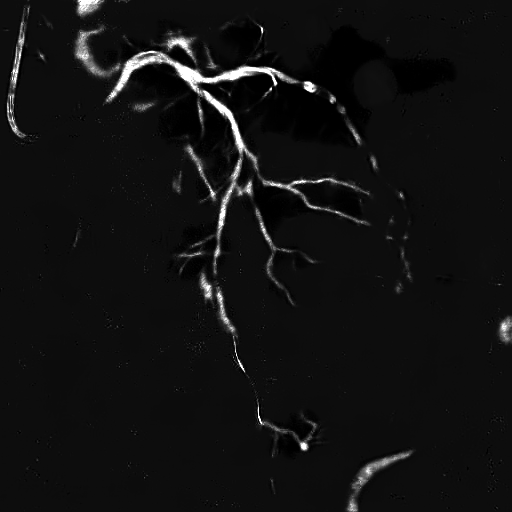

In [61]:
out_merge

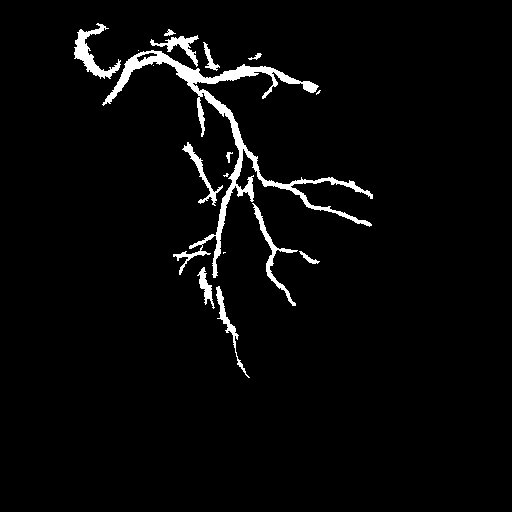

In [62]:
mask_merge

0 78.5 1.242
1 263.0 1.585
2 367.5 1.258
3 44.0 1.106
4 68.5 1.555
5 20.0 0.732
6 66.5 1.09
7 16.0 0.562
8 19.0 0.815
9 41.5 0.803
10 56.5 1.518
11 203.0 1.114
12 36.5 0.851
13 25.0 0.778
14 63.5 1.404
15 60.5 0.667
16 46.0 0.976
17 77.0 1.368
18 50.0 1.103
19 8218.0 4.645
20 4289.0 2.092


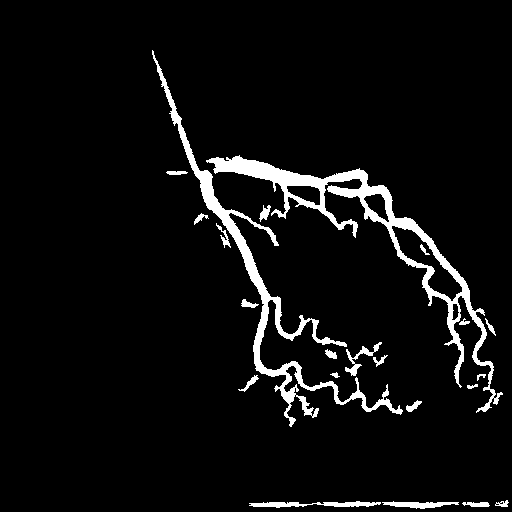

In [3]:
sp = np.array(mask_merge)

conts, _ = cv2.findContours(sp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bg = np.zeros((512,512)).astype('uint8')
rm_conts = []
for idx, cont in enumerate(conts):
    area = cv2.contourArea(cont)
    perimeter= cv2.arcLength(cont,True)
    apr = area/(perimeter+1e-5)
    print(idx, area, round(apr,3))
    if apr>2.5 and area<3000:
        cv2.fillPoly(sp, [cont], (125,125,125))
        print('***')
Image.fromarray(sp)

In [4]:
# 如果要存储
B2.save(f'datasets/eval_sample/img/{fname}.png')
# mask_merge.save(f'datasets/eval_sample/mask/{fname}.png')
mask_cld.save(f'datasets/eval_sample/mask/{fname}.png')

In [262]:
bg = np.zeros((512,512)).astype('uint8')
cv2.drawContours(bg,conts,17, (255,255,255),1)
Image.fromarray(bg)

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/drawing.cpp:2498: error: (-215:Assertion failed) 0 <= contourIdx && contourIdx < (int)last in function 'drawContours'
